# Try HMM

https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [60]:
# imports
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [61]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [62]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 203475
Percentage duplicate: 20.904414506877732


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [63]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1).astype(np.int)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1).astype(np.int)
data_turk.shape

(769884, 1)

In [64]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [65]:
lab_model = hmm.MultinomialHMM(n_components=6, n_iter=50, verbose=True).fit(data_lab, lab_lengths)
lab_model

1      -50222.8734             +nan
         2      -48737.9006       +1484.9728
         3      -46394.0910       +2343.8097
         4      -39891.5201       +6502.5709
         5      -30951.8443       +8939.6757
         6      -22198.5166       +8753.3277
         7      -13619.5761       +8578.9406
         8      -12680.3036        +939.2724
         9      -12609.9713         +70.3323
        10      -12384.3700        +225.6013
        11      -10152.5268       +2231.8432
        12       -8640.5757       +1511.9511
        13       -8452.2508        +188.3249
        14       -8396.1361         +56.1146
        15       -8386.8847          +9.2514
        16       -8385.8379          +1.0468
        17       -8385.6040          +0.2339
        18       -8385.2690          +0.3350
        19       -8384.4659          +0.8031
        20       -8383.0134          +1.4525
        21       -8381.3872          +1.6262
        22       -8380.0773          +1.3099
        23       -8

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=6,
               n_iter=50, params='ste',
               random_state=RandomState(MT19937) at 0x12EAA73ED08,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [66]:
lab_model.sample(10)

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=int64),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [67]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.951, 0.015, 0.009, 0.002, 0.02 , 0.004],
       [0.027, 0.944, 0.015, 0.003, 0.007, 0.004],
       [0.009, 0.023, 0.931, 0.01 , 0.01 , 0.016],
       [0.002, 0.001, 0.01 , 0.956, 0.012, 0.019],
       [0.018, 0.005, 0.008, 0.019, 0.945, 0.005],
       [0.006, 0.005, 0.012, 0.021, 0.006, 0.95 ]])

In [68]:
turk_model = hmm.MultinomialHMM(n_components=6, n_iter=50, verbose=True).fit(data_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

1    -1404611.2431             +nan
         2    -1269526.0082     +135085.2350
         3    -1161730.8863     +107795.1219
         4     -938323.0905     +223407.7959
         5     -751927.9712     +186395.1193
         6     -619808.0931     +132119.8781
         7     -497180.6475     +122627.4456
         8     -411783.8676      +85396.7800
         9     -334843.6725      +76940.1950
        10     -318233.3805      +16610.2920
        11     -317614.8990        +618.4815
        12     -317251.5475        +363.3515
        13     -316923.3021        +328.2454
        14     -316611.7982        +311.5040
        15     -316308.1594        +303.6387
        16     -316006.2903        +301.8691
        17     -315700.7540        +305.5363
        18     -315385.9929        +314.7611
        19     -315056.3124        +329.6805
        20     -314705.9863        +350.3261
        21     -314329.2257        +376.7606
        22     -313919.9604        +409.2653
        23     -313

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=6,
               n_iter=50, params='ste',
               random_state=RandomState(MT19937) at 0x12EAA73ED08,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [69]:
# Show transition matrix of hidden states.
# TODO: compute actual system trasitions with n-grams.

np.round(turk_model.transmat_, 2)

array([[0.95, 0.  , 0.02, 0.02, 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.95, 0.02, 0.  , 0.  ],
       [0.07, 0.01, 0.04, 0.81, 0.04, 0.03],
       [0.01, 0.  , 0.01, 0.02, 0.94, 0.01],
       [0.01, 0.  , 0.  , 0.02, 0.01, 0.95]])

In [70]:
# Create a new data samples of length 10.

np.array(turk_model.sample(10)[0]).reshape(-1)


array([3, 1, 1, 1, 3, 1, 1, 3, 1, 3], dtype=int64)

In [71]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-1502.6702181371604,
 -1400.302849610634,
 -1397.9726212080452,
 -484.8350037507124,
 -342.7525719337442,
 -1867.9219769887281,
 -805.5357288710223,
 -268.10370531985444,
 -1704.8575136331417,
 -288.7633952122658,
 -2223.507394898074,
 -2229.4753227379647,
 -1243.2540937241854,
 -1214.306173151002]

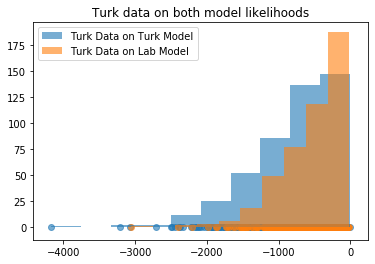

In [72]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

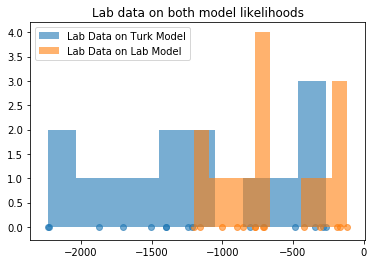

In [73]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

In [74]:
print(lab_model.score(data_lab, lab_lengths))
print(turk_model.score(data_lab, lab_lengths))
print()
print(lab_model.score(data_turk, turk_lengths))
print(turk_model.score(data_turk, turk_lengths))

-8378.371301171734
-13966.494292470226

-215663.66874522838
-306771.5138369487


In [75]:
turk_data_turk_model
turk_data_lab_model 
lab_data_turk_model
lab_data_lab_model

[-850.07163071527,
 -767.077721928565,
 -765.5029970765905,
 -306.32574195933654,
 -190.74881602439768,
 -998.9518173983432,
 -418.9734624536694,
 -118.86679159540574,
 -898.3504309197361,
 -166.63862106097167,
 -1155.0942074153797,
 -1201.030171931524,
 -714.218828745247,
 -701.644143993157]

# Plotting results

It is hard to visulaise these results, so show them as a scatter point and a 2D histogram.
A straight line of y = x will be shown.
A point on this line will have the identily likelihoods to belong to either model.



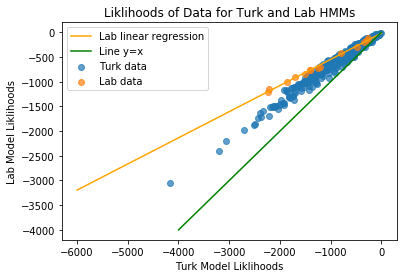

In [139]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-6000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-4000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

plt.show()

# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [77]:

# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths, reg)
reclassified_lab_labels

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

In [78]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

In [79]:
print('Number of new turk labels, number of new lab labels:')
reclassified_turk_labels.count(0), reclassified_turk_labels.count(1)

Number of new turk labels, number of new lab labels:


(341, 120)

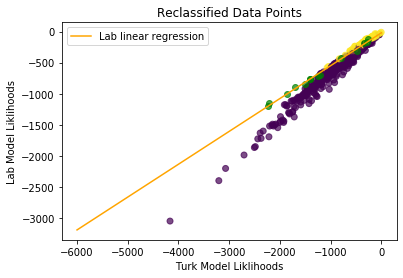

In [132]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, c='g', alpha=0.7)

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-6000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')
plt.legend()

plt.show()

# These scatterplots show that there is not anywhere near as much variance with the turk model predictions as the lab model predictions.
# Probably due to the fact we didtnt have much data to train the lab model with.
# The positive quadrant shows that shows that while the turk likelihoods are always slightly higher, theyre directly correlated and not much difference.
# Can we accume any positive likelihood from the lab model using turk data means theyre paying attention?

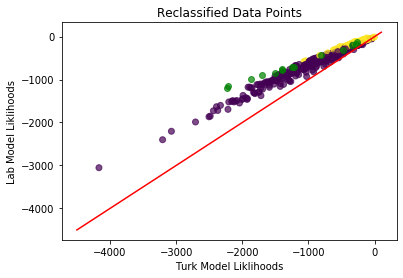

In [81]:
# Plot reclassified data
'''
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7)
'''
#plt.scatter(lab_data_turk_model+turk_data_turk_model, lab_data_lab_model+turk_data_lab_model, c=reclassified_turk_labels+reclassified_lab_labels, alpha=0.7)

plt.scatter(turk_data_turk_model, turk_data_lab_model, c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, c='g', alpha=0.7)

x = np.linspace(-4500,100,100)
y = 1*x+0

plt.plot(x,y, 'r')
plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
plt.show()


Turk likelihoods  Lab likelihoods  Difference   ID
0      -1502.670218      -850.071631 -652.598587  ID1
1      -1400.302850      -767.077722 -633.225128  ID2
2      -1397.972621      -765.502997 -632.469624  ID3
3       -484.835004      -306.325742 -178.509262  ID4
4       -342.752572      -190.748816 -152.003756  ID5


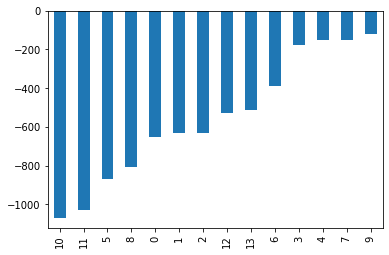

In [82]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_m_lab['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk likelihoods  Lab likelihoods  Difference              ID
0       -239.325961      -132.160028 -107.165933  A35YFAFWP33C70
1       -235.195315      -131.115025 -104.080290  A33XI8ZN4NZ0SQ
2       -391.827976      -225.527655 -166.300322  A1ZG7VYH0DUEXW
3       -319.492270      -137.456568 -182.035701  A1RXG8RE0SJ4LC
4        -40.913714       -39.052585   -1.861129   AUDH0P4ZHJKS2


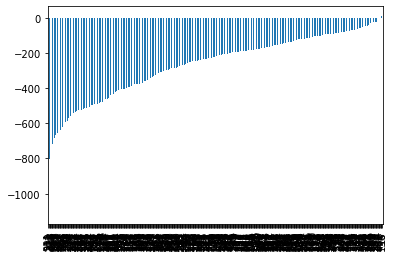

In [83]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

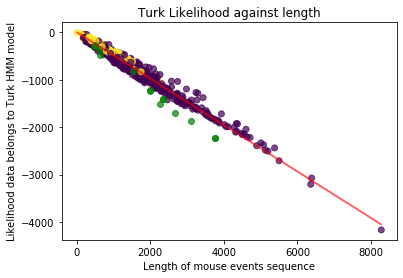

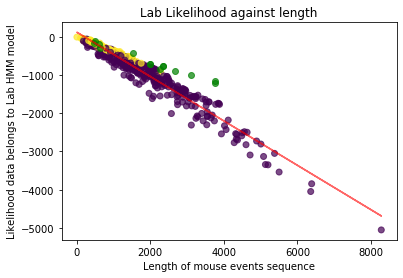

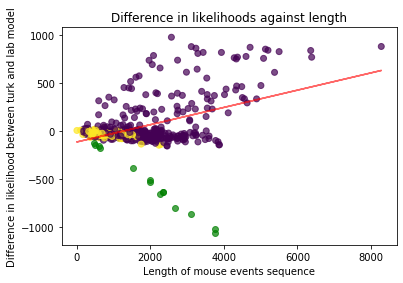

In [133]:

# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='g', alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()


# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='g', alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], c='g', alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()


# Link between length of mouse events and likelihood?

From an breif exploration of the likelihoods and through tableau it looks like the users with longer sequences have mainly high likelihoods for turk data, and shorter sequences have higher likelihood for lab data.

Plot likelihood difference and length of mouse evetns to see if there is actually a strong correlation.



In [85]:
df_turk_diff['Turk likelihoods']

0      -239.325961
1      -235.195315
2      -391.827976
3      -319.492270
4       -40.913714
          ...     
456      -3.627559
457    -830.067057
458    -831.254977
459    -104.573347
460   -1199.254138
Name: Turk likelihoods, Length: 461, dtype: float64

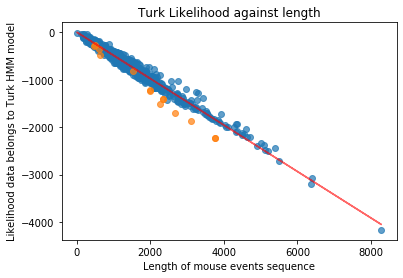

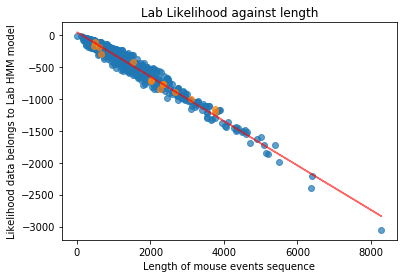

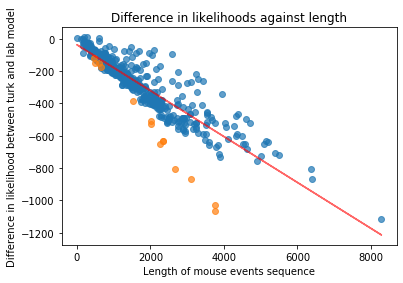

In [86]:
from sklearn.linear_model import LinearRegression

# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

In [87]:
from scipy.stats import norm

In [88]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
'''
from scipy.stats import norm
from scipy.stats import lognorm

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

mu, std = norm.fit(turk_lengths)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

#dist=lognorm([std],loc=mean)
lognorm_dist = lognorm(s=std, loc=mu)
p2 = lognorm(*lnorm)

plt.plot(x, lognorm_dist.pdf(x), 'y', linewidth=2)

title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()



from scipy.stats import norm

data = turk_lengths
ogdata = np.log(data)
estimated_mu, estimated_sigma = norm.fit(logdata)

x = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')


# plot histogram in log space
logdata = np.log(data)
plt.hist(logdata, bins=25)


shape,loc,scale = lognorm.fit(data)

x = np.logspace(0, 5, 200)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.plot(x, pdf, 'r')

''';

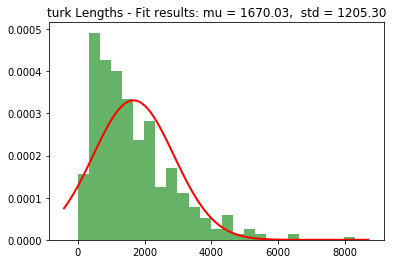

In [89]:
# See if turk data follows a distrinution

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

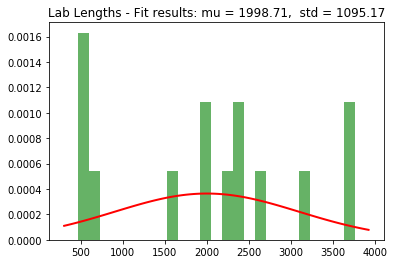

In [90]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

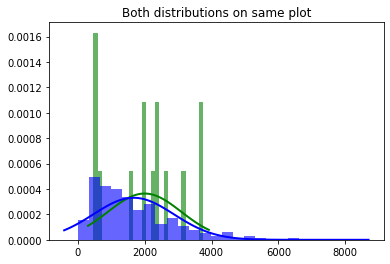

In [91]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'b', linewidth=2)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1679.72,  std = 1203.48')

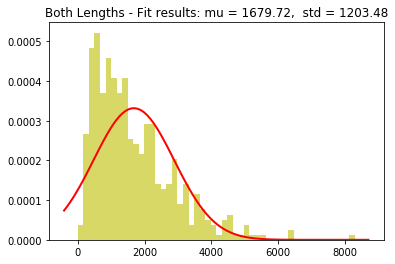

In [92]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=50, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

In [93]:
# Shows we need to create 367 (381-14) lab samples to have classes of the same length.
# OR: synthesize 381 lab datas, then use the actual lab data as my TESTING set.
len(turk_lengths), len(lab_lengths)

(461, 14)

In [94]:
len(lab_lengths + turk_lengths)

475

In [95]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = len(turk_lengths)   # Create enough sampels so classes are equally sized

# Create gaussian parameters from all data, as there wasnt much difference
mu, std = norm.fit(turk_lengths + lab_lengths)
generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   # Creating 300 more samples would make the classes even ish.

# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
# TODO: Try a log normal, but wasnt working for me
generated_lengths = abs(generated_lengths).astype(int)



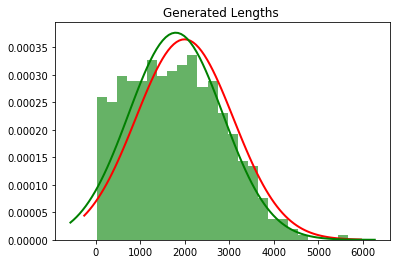

In [96]:
# Shows created data follows pretty much the same distribution as the original data.

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

# Original lab distribution
mu, std = norm.fit(lab_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

# New generated distribution
mu, std = norm.fit(generated_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)

title = "Generated Lengths "
plt.title(title)

plt.show()

In [97]:
# Generate the data. Note this will take a long time.

created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

461

In [98]:
# we have array of length 381, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [99]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,html,ID0
...,...,...
829843,alloc-slider-5,ID460
829844,alloc-slider-5,ID460
829845,alloc-slider-5,ID460
829846,alloc-slider-5,ID460


In [100]:
df.to_csv('created_labs.csv')

Tableau images https://imgur.com/a/FagaiQW
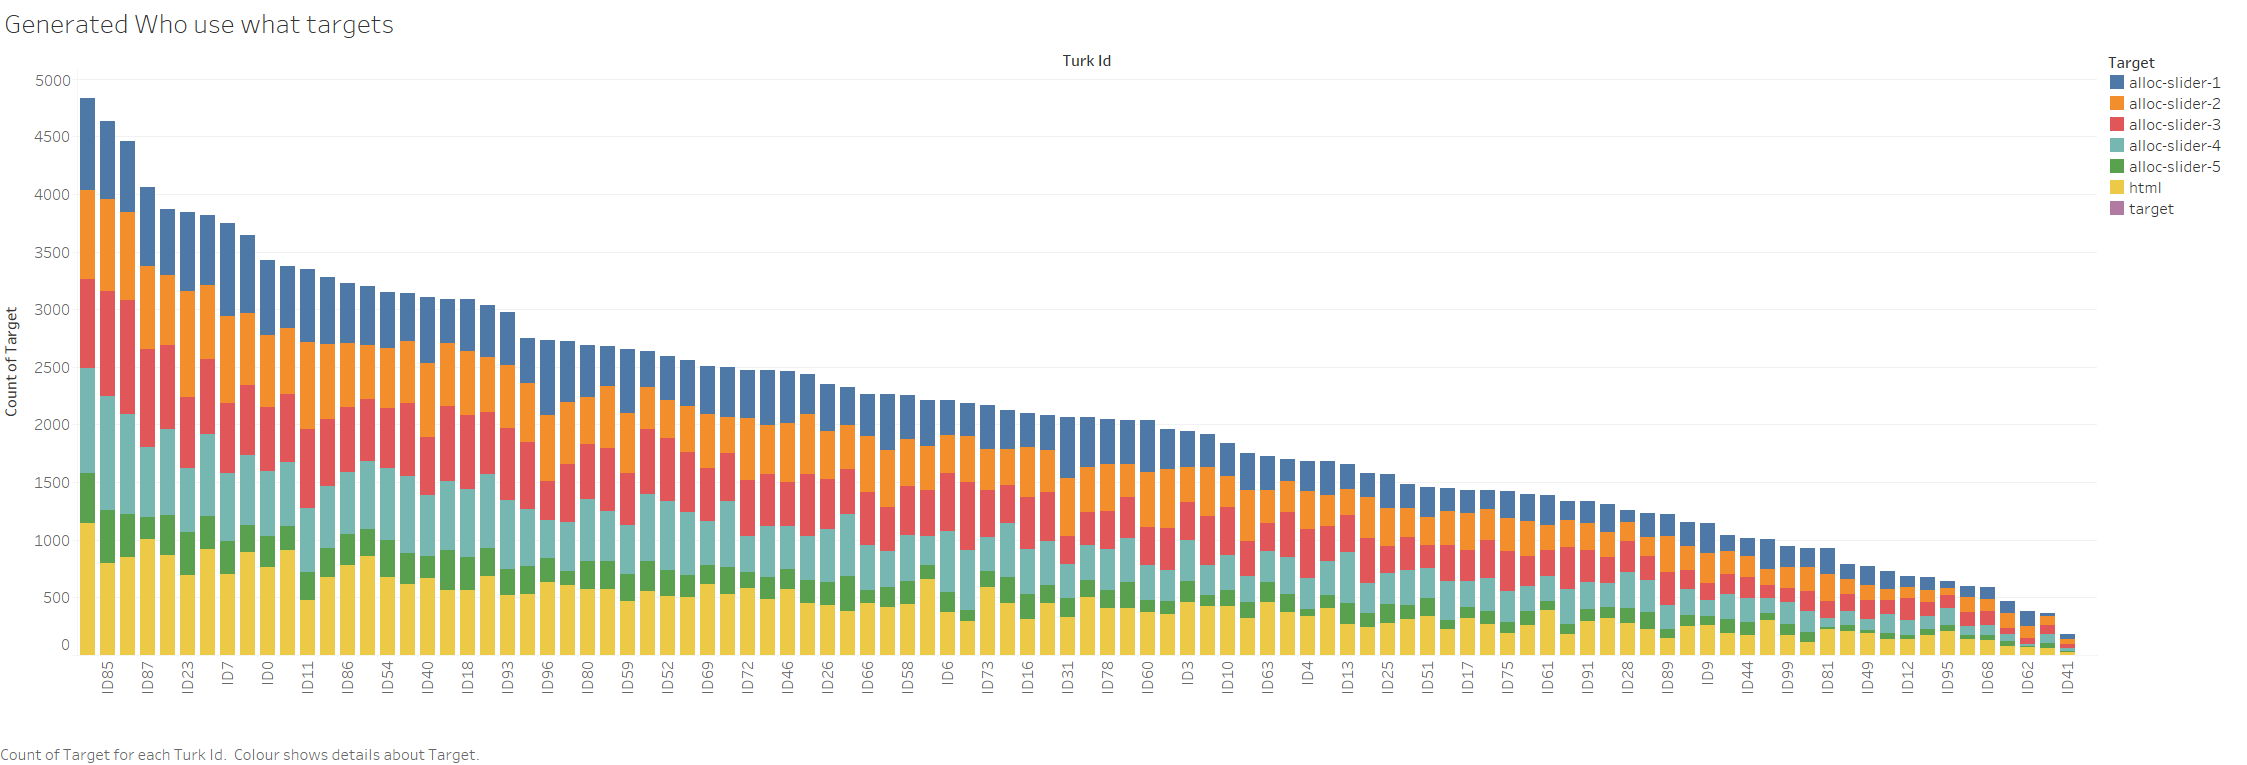

TODO: Remove generated lab data where not all sliders have been selected.
Some of the generated data doesnt have any records of slider-1 being selected for example

Now weve generated some more data samples see if the generated data sampels would be identified by the lab hmm not the turk hmm.



In [101]:
flatten_created_data = np.concatenate(created_data).ravel().astype(int).reshape(-1,1)


reclassified_labels = reclassify_samples(turk_model, lab_model, flatten_created_data, generated_lengths, reg)    # Try generated lab data

print('Number of new turk labels, number of new lab labels:')
reclassified_labels.count(0), reclassified_labels.count(1)

Number of new turk labels, number of new lab labels:


(454, 7)

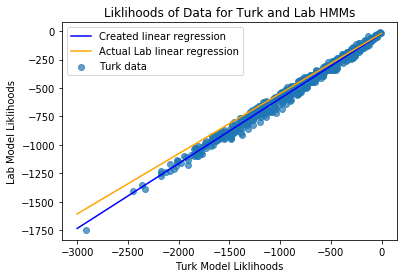

In [142]:
#############################################################################################################################

created_data_turk_model = model_score_list(turk_model, flatten_created_data, generated_lengths)
created_data_lab_model = model_score_list(lab_model, flatten_created_data, generated_lengths)

plt.scatter(created_data_turk_model, created_data_lab_model, alpha=0.7, label='Turk data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(created_data_turk_model).reshape(-1,1)
y = np.array(created_data_lab_model).reshape(-1,1)
created_reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-3000,0,100)
y = created_reg.coef_[0][0]*x + created_reg.intercept_[0]
plt.plot(x, y, 'blue', label='Created linear regression')

x = np.linspace(-3000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Actual Lab linear regression')

plt.legend()

plt.show()

In [102]:
#idea: maybe the liklihoods are messed up because of the inbalanece in training size when orriginally training?
# Try duplicating training samples NOW, or retrain on the created data.

# Increaed number of iterations from 10 to 30
generated_model = hmm.MultinomialHMM(n_components=6, n_iter=50, verbose=True).fit(flatten_created_data, generated_lengths.tolist()) # not sure why not working.
generated_model

1    -1490166.1904             +nan
         2    -1465068.9799      +25097.2105
         3    -1435270.9800      +29797.9999
         4    -1339103.5855      +96167.3945
         5    -1134287.3588     +204816.2267
         6     -993557.2397     +140730.1191
         7     -908277.6454      +85279.5943
         8     -767749.3544     +140528.2911
         9     -520136.4439     +247612.9105
        10     -390294.5360     +129841.9079
        11     -380511.4453       +9783.0907
        12     -380239.7543        +271.6910
        13     -380201.8498         +37.9046
        14     -380186.0344         +15.8154
        15     -380175.5664         +10.4680
        16     -380168.2990          +7.2674
        17     -380163.5735          +4.7254
        18     -380160.5696          +3.0040
        19     -380158.5313          +2.0382
        20     -380156.9920          +1.5393
        21     -380155.7216          +1.2704
        22     -380154.6155          +1.1061
        23     -380

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=6,
               n_iter=50, params='ste',
               random_state=RandomState(MT19937) at 0x12EAA73ED08,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [103]:
reclassify_samples(turk_model, generated_model, data_turk, turk_lengths, reg) 

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Turk likelihoods  Lab likelihoods  Difference              ID
0       -239.325961      -173.272960  -66.053001  A35YFAFWP33C70
1       -235.195315      -210.105792  -25.089522  A33XI8ZN4NZ0SQ
2       -391.827976      -348.223862  -43.604115  A1ZG7VYH0DUEXW
3       -319.492270      -299.780379  -19.711891  A1RXG8RE0SJ4LC
4        -40.913714       -51.153556   10.239842   AUDH0P4ZHJKS2


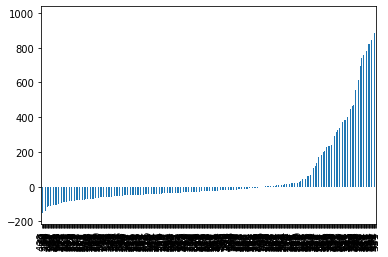

In [104]:
df_turk_diff = compare_model_liklihoods(turk_model, generated_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# NLP methods again 

See if the naive bayes of n-grams distribution will work better.

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [106]:
def make_cm(cm):
    # Makes a confustion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.suptitle('0=online, 1=lab')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [107]:
created_data[0][:10]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [108]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
generated_targets = targets_to_string(df)

turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )
generated_labels = np.ones( len(generated_targets) )


In [109]:
# TODO: I think I only get the first 114 because i only generate 100 new samples??
# TODO: Generate 381 new sampels and see how that effects accuracy of algorithms

print(len(turk_labels), len(lab_labels), len(generated_labels))

# Removed actual lab labels from training data.
X = np.concatenate((turk_targets, generated_targets)).ravel()
X_test = lab_targets
y = np.concatenate((turk_labels, generated_labels)).ravel()
y_test = lab_labels.ravel()

len(X), len(y)

461 14 461


(922, 922)

In [110]:
# OLD
# Test train split 
#X_train, X_test, y_train, y_test = train_test_split(X, y)

Accuracy: 0.69 (+/- 0.07)
f1 score: 0.67 (+/- 0.09)
accuracies:  [0.70810811 0.75675676 0.67391304 0.6576087  0.66304348]
f1 scores:   [0.68796852 0.74925454 0.65010142 0.63147353 0.62586908]
[[203 258]
 [ 26 435]]


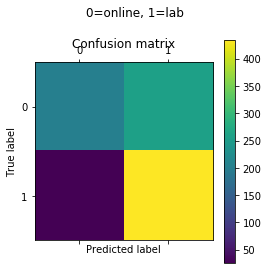

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


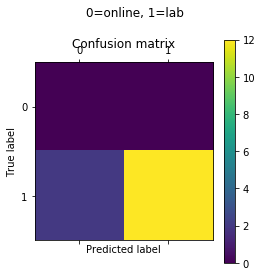

In [111]:
# Try NB model with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)').fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB model on actual lab / testing data
X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [112]:
 # This seems to say that nb finds it easiest to identify lab data as lab data.
 # This makes sence as lab data is created forom an actual model and distribution rather than being created randomly.
# THen we have to consider the actual question of the dis, can we identify whos paying attention?
# Maybe say the 12ish turks falsly predicted to be labs were paying attention??
# Seems like a big leap to say that.

 # TODO do with full dataset of 300 for turks, so generate more lab data.

# Naive Bayes with N-grams

above did naive bayes on counts of items, see if looking at ngrams effects accuracy.

Accuracy: 0.70 (+/- 0.07)
f1 score: 0.67 (+/- 0.09)
accuracies:  [0.71351351 0.76216216 0.67391304 0.66304348 0.67391304]
f1 scores:   [0.69283544 0.75434573 0.65010142 0.63617808 0.63793782]
[[203 258]
 [ 23 438]]


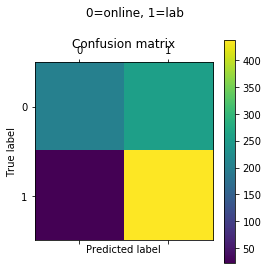

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


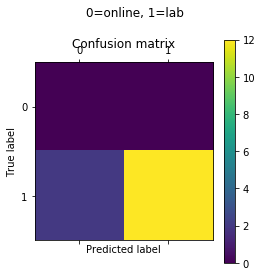

In [113]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [114]:
# AMAZING!!!!!
# Very clearly can seperate the classes looking at the bigrams!!!!!

# Still questions of how to extend that to attention or not lol.
# Potentially add section on how to generate more lab data since we cant do lab studdies because of corona.

Accuracy: 0.70 (+/- 0.08)
f1 score: 0.68 (+/- 0.09)
accuracies:  [0.71351351 0.77297297 0.67391304 0.66847826 0.67934783]
f1 scores:   [0.69283544 0.76454545 0.64791427 0.64088946 0.6453099 ]
[[204 257]
 [ 17 444]]


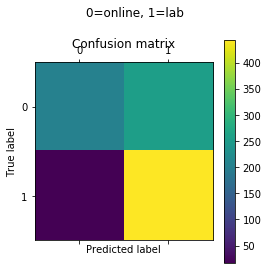

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


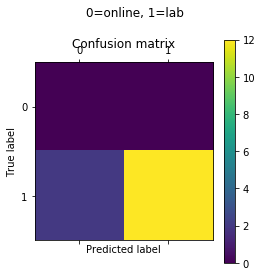

In [115]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(3, 3)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [116]:
# Retry the log normal distribution for histograms.

In [117]:
# TODO TODO TODO: SEE HOW MUCH LOWER LIKLIHOOD THE LAB DATAPOINTS GET ON THE TURK HMM. IF THEYRE ALL STRONG OUTLIERS (10%-20%) THEN WE CAN SAY THESE POINTS CLEARLY DONT BELONG TO THIS CLASS AND THIS IS BECAUSE AS LAB STUDY PARTICIPANTS THEYRE PAYING ATTENTION WHICH HAS CAUSED THEM TO ACT DIFFERENTLY.  

In [118]:
# Curious TODO: See if the states of the HMM relate to the sequence. for example does slider-1 actually repalte to state 1, or does it relate to state 1 and state 2 or even jsut state 6